- Load Dataset from Hugging Face: https://huggingface.co/datasets/stanfordnlp/imdb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install datasets
from datasets import load_dataset
import pandas as pd

# Load and export IMDB dataset
dataset = load_dataset("stanfordnlp/imdb")
target_folder = '/content/drive/MyDrive/SPNLP/Capstone/'

# Save train, test, and combined datasets
train_file = f"{target_folder}/imdb_train.csv"
test_file = f"{target_folder}/imdb_test.csv"
combined_file = f"{target_folder}/imdb_combined.csv"

dataset["train"].to_csv(train_file)
dataset["test"].to_csv(test_file)

pd.concat([
    pd.read_csv(train_file),
    pd.read_csv(test_file)
], ignore_index=True).to_csv(combined_file, index=False)

print(f"Train: {train_file}\nTest: {test_file}\nCombined: {combined_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Train: /content/drive/MyDrive/SPNLP/Capstone//imdb_train.csv
Test: /content/drive/MyDrive/SPNLP/Capstone//imdb_test.csv
Combined: /content/drive/MyDrive/SPNLP/Capstone//imdb_combined.csv


In [ ]:
# Load the dataset from the CSV file
dataset = pd.read_csv("/content/drive/MyDrive/SPNLP/Capstone/imdb_combined.csv")

- Check for null values

In [ ]:
null_counts = dataset.isnull().sum()
print(null_counts)

text     0
label    0
dtype: int64


There are no null values for dataset.

**Preprocessing Pipeline**

1. Drop Duplicate Reviews
2. Remove hyperlinks
3. Remove HTML Tags
4. Expand Contractions
5. Convert Emoticons to Text
6. Remove Non-ASCII Characters
7. Convert to Lowercase

In [ ]:
!pip install contractions
!pip install -U emot
import pandas as pd
import re
import contractions
import emot

# Initialize the emot library object
emot_obj = emot.core.emot()

# Preprocessing functions
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove hyperlinks
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = contractions.fix(text)  # Expand contractions
    emoticons_dict = emot_obj.emoticons(text)
    if emoticons_dict['flag']:
        for i, value in enumerate(emoticons_dict['value']):
            text = re.sub(re.escape(value), f" {emoticons_dict['mean'][i]} ", text)
    text = "".join(char for char in text if ord(char) < 128).strip()  # Remove non-ASCII characters
    text = text.lower()  # Convert to lowercase
    return text

# Full preprocessing pipeline
def preprocess_pipeline(df):
    df = df.drop_duplicates(subset=["text"])  # Drop duplicate reviews
    df['text'] = df['text'].apply(preprocess_text)
    return df

# Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/SPNLP/Capstone/imdb_combined.csv")

# Apply preprocessing pipeline
dataset = preprocess_pipeline(dataset)

# Save the preprocessed dataset
preprocessed_file = "/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_preprocessed.csv"
dataset.to_csv(preprocessed_file, index=False)

print(f"Preprocessing complete. Saved to: {preprocessed_file}")


<ipython-input-3-711a9f655df2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(preprocess_text)


Preprocessing complete. Saved to: /content/drive/MyDrive/SPNLP/Capstone/imdb_combined_preprocessed.csv


- Lemmatization using spacy. Pipeline includes tokenization, POS tagging, and lemmatization.

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Lemmatization function using pipe() for batch processing
def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=64, disable=["parser", "ner"]), desc="Lemmatizing"):
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized_texts

# Load your dataset
dataset = pd.read_csv("/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_preprocessed.csv")

# Apply lemmatization
dataset['text'] = lemmatize_texts(dataset['text'])

# Save the result as a CSV
output_path = "/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_lemmatized.csv"
dataset.to_csv(output_path, index=False)

print(f"Lemmatized dataset saved to: {output_path}")


Lemmatizing: 49582it [16:20, 50.57it/s]


Lemmatized dataset saved to: /content/drive/MyDrive/SPNLP/Capstone/imdb_combined_lemmatized.csv


- Stopword removal

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function for stopword removal using pipe() for batch processing
def remove_stopwords(texts):
    filtered_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=64, disable=["parser", "ner", "lemmatizer"]), desc="Removing stopwords"):
        filtered_texts.append(" ".join([token.text for token in doc if not token.is_stop]))
    return filtered_texts

# Load dataset
dataset = pd.read_csv("/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_lemmatized.csv")

# Apply stopword removal
dataset['text'] = remove_stopwords(dataset['text'])

# Save the result to a CSV
output_path = "/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_stopwords.csv"
dataset.to_csv(output_path, index=False)

print(f"Stopword-removed dataset saved to: {output_path}")


Removing stopwords: 49582it [14:41, 56.24it/s]


Stopword-removed dataset saved to: /content/drive/MyDrive/SPNLP/Capstone/imdb_combined_stopwords.csv


- Split dataset into 80% train and 20% test. This is done before feature extraction to ensure consistent train-test data for evaluation, as fine-tuning DistilBERT requires raw data as input.

In [ ]:
# Split dataset to 80% train and 20% test
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/imdb_combined_stopwords.csv')

# Split the dataset into 80% train and 20% test
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Save the splits to CSV files
train_data_path = '/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtrain.csv'
test_data_path = '/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtest.csv'

train_data.to_csv(train_data_path, index=False)
test_data.to_csv(test_data_path, index=False)

print(f"Train and test datasets saved to {train_data_path} and {test_data_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train and test datasets saved to /content/drive/MyDrive/SPNLP/Capstone/imdb_FEtrain.csv and /content/drive/MyDrive/SPNLP/Capstone/imdb_FEtest.csv


- Feature extraction using DistilBert

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import torch
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to('cuda')  # Move model to GPU

# Function for batch feature extraction
def extract_bert_features_batch(texts, batch_size=32):
    """Extract DistilBERT features using batch processing."""
    # Tokenize all texts
    encoded_inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    input_ids = encoded_inputs['input_ids'].to('cuda')  # Move to GPU
    attention_mask = encoded_inputs['attention_mask'].to('cuda')  # Move to GPU

    # Prepare data loader
    dataset = DataLoader(list(zip(input_ids, attention_mask)), batch_size=batch_size)
    features = []

    # Extract features in batches
    with torch.no_grad():
        for batch_input_ids, batch_attention_mask in tqdm(dataset, desc="Extracting features"):
            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            cls_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # Move results to CPU
            features.extend(cls_embeddings)
    return np.array(features)

# Process train data
train_data = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtrain.csv')
X_train = extract_bert_features_batch(train_data['text'].tolist(), batch_size=32)
y_train = train_data['label'].values

np.save('/content/drive/MyDrive/SPNLP/Capstone/X_train.npy', X_train)
np.save('/content/drive/MyDrive/SPNLP/Capstone/y_train.npy', y_train)
print("Train features extracted and saved.")

# Process test data
test_data = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtest.csv')
X_test = extract_bert_features_batch(test_data['text'].tolist(), batch_size=32)
y_test = test_data['label'].values

np.save('/content/drive/MyDrive/SPNLP/Capstone/X_test.npy', X_test)
np.save('/content/drive/MyDrive/SPNLP/Capstone/y_test.npy', y_test)
print("Test features extracted and saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting features: 100%|██████████| 1240/1240 [10:18<00:00,  2.00it/s]


Train features extracted and saved.


Extracting features: 100%|██████████| 310/310 [02:34<00:00,  2.01it/s]

Test features extracted and saved.


- Split train data to train and validation datasets and train model using Logistic Regression

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3975
           1       0.83      0.84      0.84      3958

    accuracy                           0.84      7933
   macro avg       0.84      0.84      0.84      7933
weighted avg       0.84      0.84      0.84      7933

Validation report saved to: /content/drive/MyDrive/SPNLP/Capstone/logistic_regression_val_report.json


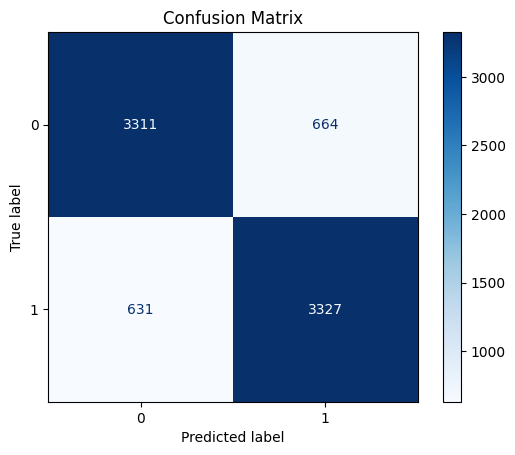

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/LRconfusion_matrix.png


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Load the preprocessed features and labels
X_train_full = np.load('/content/drive/MyDrive/SPNLP/Capstone/X_train.npy')
y_train_full = np.load('/content/drive/MyDrive/SPNLP/Capstone/y_train.npy')

# Split training data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(model, '/content/drive/MyDrive/SPNLP/Capstone/logistic_regression_model.pkl')

# Evaluate on the validation set
y_val_pred = model.predict(X_val)

# Print Classification Report
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Save classification report to a file
report = classification_report(y_val, y_val_pred, output_dict=True)
report_file = '/content/drive/MyDrive/SPNLP/Capstone/logistic_regression_val_report.json'
with open(report_file, 'w') as f:
    import json
    json.dump(report, f)
print(f"Validation report saved to: {report_file}")

# Compute and Display Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/SPNLP/Capstone/LRconfusion_matrix.png')
plt.show()

print("Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/LRconfusion_matrix.png")


Mounted at /content/drive

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4980
           1       0.84      0.84      0.84      4937

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917

Logistic Regression Test Report saved to: /content/drive/MyDrive/SPNLP/Capstone/logistic_regression_test_report.json


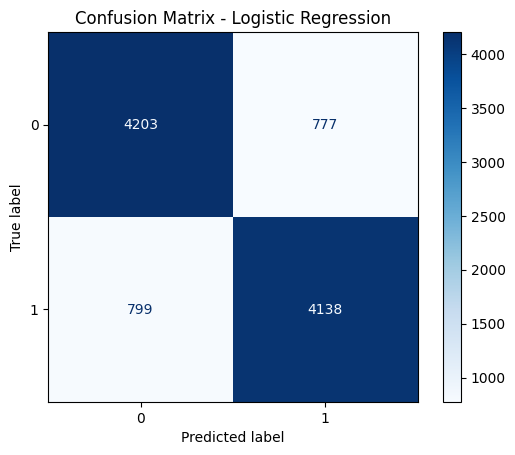

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/LR_confusion_matrix_test.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import joblib

# Load Test Data
X_test = np.load('/content/drive/MyDrive/SPNLP/Capstone/X_test.npy')
y_test = np.load('/content/drive/MyDrive/SPNLP/Capstone/y_test.npy')

# Load the Trained LR Model
lr_model = joblib.load('/content/drive/MyDrive/SPNLP/Capstone/logistic_regression_model.pkl')

# Predict on Test Data
y_test_pred_lr = lr_model.predict(X_test)

# Print and Save Classification Report
lr_report = classification_report(y_test, y_test_pred_lr, output_dict=True)
lr_report_file = '/content/drive/MyDrive/SPNLP/Capstone/logistic_regression_test_report.json'
with open(lr_report_file, 'w') as f:
    json.dump(lr_report, f)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_lr))
print(f"Logistic Regression Test Report saved to: {lr_report_file}")

# Compute and Save Confusion Matrix
lr_conf_matrix = confusion_matrix(y_test, y_test_pred_lr)
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix, display_labels=lr_model.classes_)
lr_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
lr_cm_file = '/content/drive/MyDrive/SPNLP/Capstone/LR_confusion_matrix_test.png'
plt.savefig(lr_cm_file)
plt.show()
print(f"Confusion matrix saved to: {lr_cm_file}")

- Split train data to train and validation datasets and train model using SVM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3975
           1       0.84      0.85      0.84      3958

    accuracy                           0.84      7933
   macro avg       0.84      0.84      0.84      7933
weighted avg       0.84      0.84      0.84      7933

Validation report saved to: /content/drive/MyDrive/SPNLP/Capstone/svm_val_report.json


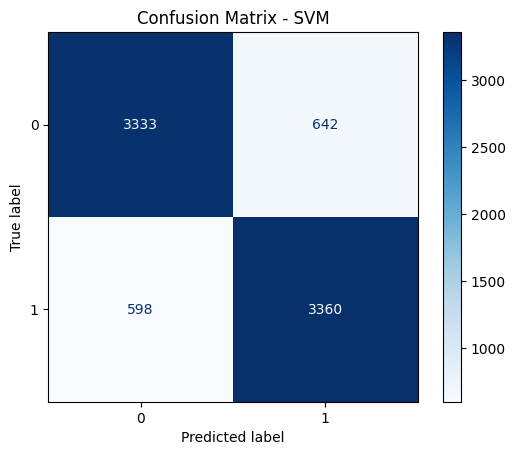

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/svm_confusion_matrix.png
SVM model and scaler saved!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Load the preprocessed features and labels
X_train_full = np.load('/content/drive/MyDrive/SPNLP/Capstone/X_train.npy')
y_train_full = np.load('/content/drive/MyDrive/SPNLP/Capstone/y_train.npy')

# Step 1: Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Step 2: Scale the data (SVM requires scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 3: Train SVM with default parameters
svm_model = SVC()  # Default kernel='rbf', C=1.0, gamma='scale'
svm_model.fit(X_train_scaled, y_train)

# Step 4: Evaluate on the validation set
y_val_pred = svm_model.predict(X_val_scaled)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 5: Save classification report to a file
report = classification_report(y_val, y_val_pred, output_dict=True)
report_file = '/content/drive/MyDrive/SPNLP/Capstone/svm_val_report.json'
with open(report_file, 'w') as f:
    import json
    json.dump(report, f)
print(f"Validation report saved to: {report_file}")

# Step 6: Compute and Display Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.savefig('/content/drive/MyDrive/SPNLP/Capstone/svm_confusion_matrix.png')
plt.show()

print("Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/svm_confusion_matrix.png")

# Step 7: Save the trained SVM model and scaler
joblib.dump(svm_model, '/content/drive/MyDrive/SPNLP/Capstone/svm_default_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/SPNLP/Capstone/scaler.pkl')
print("SVM model and scaler saved!")



SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4980
           1       0.84      0.84      0.84      4937

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917

SVM Test Report saved to: /content/drive/MyDrive/SPNLP/Capstone/svm_test_report.json


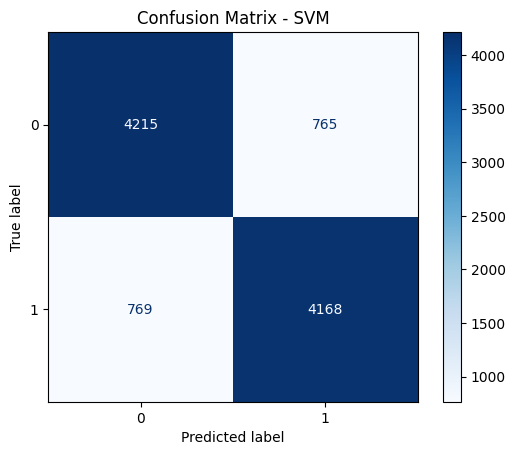

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/SVM_confusion_matrix_test.png


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import joblib

# Load Test Data
X_test = np.load('/content/drive/MyDrive/SPNLP/Capstone/X_test.npy')
y_test = np.load('/content/drive/MyDrive/SPNLP/Capstone/y_test.npy')

# Load the Trained SVM Model and Scaler
svm_model = joblib.load('/content/drive/MyDrive/SPNLP/Capstone/svm_default_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/SPNLP/Capstone/scaler.pkl')

# Scale Test Data
X_test_scaled = scaler.transform(X_test)

# Predict on Test Data
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Print and Save Classification Report
svm_report = classification_report(y_test, y_test_pred_svm, output_dict=True)
svm_report_file = '/content/drive/MyDrive/SPNLP/Capstone/svm_test_report.json'
with open(svm_report_file, 'w') as f:
    json.dump(svm_report, f)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))
print(f"SVM Test Report saved to: {svm_report_file}")

# Compute and Save Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test, y_test_pred_svm)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_conf_matrix, display_labels=svm_model.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
svm_cm_file = '/content/drive/MyDrive/SPNLP/Capstone/SVM_confusion_matrix_test.png'
plt.savefig(svm_cm_file)
plt.show()
print(f"Confusion matrix saved to: {svm_cm_file}")

- Fine tune DistilBert for comparison with Logistic Regression and SVM

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import pandas as pd

# Load the preprocessed dataset
train_data = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtrain.csv')

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': self.labels[idx]}

# Prepare text and labels
texts = train_data['text'].tolist()  # Preprocessed text
labels = train_data['label'].tolist()  # Sentiment labels (0 or 1)

# Create dataset and dataloader
train_dataset = IMDBDataset(texts, labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load DistilBERT tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Fine-tuning parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        # Tokenize the text batch
        inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt', max_length=512)
        labels = torch.tensor(batch['label']).to(device)

        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned')
tokenizer.save_pretrained('/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned')
print("Model and tokenizer saved!")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-34dc7ce7dad5>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.2930746795996393
Epoch 2/3, Loss: 0.16513495868965683
Epoch 3/3, Loss: 0.08243786861261938
Model and tokenizer saved!


- Evaluation on test data set using fine tuned DistilBert model

Model is on device: cuda:0
Using GPU: Tesla T4
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4980
           1       0.91      0.91      0.91      4937

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917



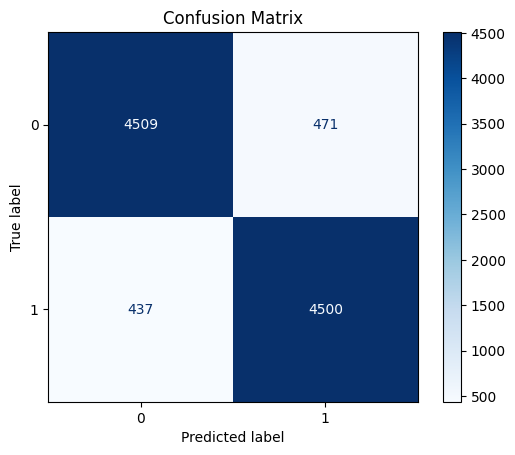

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/confusion_matrix_distilbert.png
Classification report saved to: /content/drive/MyDrive/SPNLP/Capstone/classification_report_distilbert.txt


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Load the fine-tuned model and tokenizer
model_path = '/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned'
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# Check GPU availability
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")

# Load test data
test_data_path = '/content/drive/MyDrive/SPNLP/Capstone/imdb_FEtest.csv'
test_data = pd.read_csv(test_data_path)

# Preprocessed text and labels
texts = test_data['text'].tolist()
labels = test_data['label'].tolist()

# Function to tokenize and create batches
def tokenize_texts(texts, tokenizer, batch_size=32):
    """Tokenize texts and return batches for inference."""
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs['input_ids'] = inputs['input_ids'].to(device)  # Move to GPU/CPU
    inputs['attention_mask'] = inputs['attention_mask'].to(device)  # Move to GPU/CPU

    # Split into batches
    dataset = torch.utils.data.DataLoader(
        list(zip(inputs['input_ids'], inputs['attention_mask'])),
        batch_size=batch_size
    )
    return dataset

# Tokenize the test data
test_batches = tokenize_texts(texts, tokenizer)

# Evaluate model and save results
def evaluate_model(model, test_batches, labels, save_path_report, save_path_confusion):
    model.eval()
    predictions = []

    with torch.no_grad():
        for input_ids, attention_mask in test_batches:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
            predictions.extend(preds)

    # Generate classification report
    report = classification_report(labels, predictions, output_dict=False)
    print("Classification Report:")
    print(report)

    # Save the report to a text file in Google Drive
    with open(save_path_report, 'w') as file:
        file.write("Classification Report:\n")
        file.write(report)

    # Generate and save confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(save_path_confusion)
    plt.show()
    print(f"Confusion matrix saved to: {save_path_confusion}")

# Specify save paths for results
report_save_path = '/content/drive/MyDrive/SPNLP/Capstone/classification_report_distilbert.txt'
confusion_matrix_save_path = '/content/drive/MyDrive/SPNLP/Capstone/confusion_matrix_distilbert.png'

# Run evaluation
evaluate_model(model, test_batches, labels, report_save_path, confusion_matrix_save_path)

print(f"Classification report saved to: {report_save_path}")


In [ ]:
#View layers in DistilBERT model

from transformers import DistilBertForSequenceClassification

# Step 1: Load the fine-tuned model
model_path = '/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned'
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Step 2: Print all layers and submodules
print("Model Layers and Submodules:")
for name, module in model.named_modules():
    print(name, "->", module)


Model Layers and Submodules:
 -> DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout

- Run raw data (without any processing) on Distilbert and its evaluation

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/imdb_combined.csv')

# Split the data into 80% train and 20% test
rawtrain, rawtest = train_test_split(train_data, test_size=0.2, random_state=42)

# Save the splits as separate CSV files in Google Drive
rawtrain.to_csv('/content/drive/MyDrive/SPNLP/Capstone/rawtrain.csv', index=False)
rawtest.to_csv('/content/drive/MyDrive/SPNLP/Capstone/rawtest.csv', index=False)

print("Datasets saved successfully!")


Datasets saved successfully!


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import pandas as pd

# Load the preprocessed dataset
train_data = pd.read_csv('/content/drive/MyDrive/SPNLP/Capstone/rawtrain.csv')

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': self.labels[idx]}

# Prepare text and labels
texts = train_data['text'].tolist()  # Preprocessed text
labels = train_data['label'].tolist()  # Sentiment labels (0 or 1)

# Create dataset and dataloader
train_dataset = IMDBDataset(texts, labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load DistilBERT tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Fine-tuning parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        # Tokenize the text batch
        inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt', max_length=512)
        labels = torch.tensor(batch['label']).to(device)

        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned_raw')
tokenizer.save_pretrained('/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned_raw')
print("Model and tokenizer saved!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-2-75abb0be8095>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 0.24099119059331714
Epoch 2/3, Loss: 0.12709759706808255
Epoch 3/3, Loss: 0.06991867527749855
Model and tokenizer saved!


Model is on device: cuda:0
Using GPU: Tesla T4
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      5055
           1       0.89      0.96      0.92      4945

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



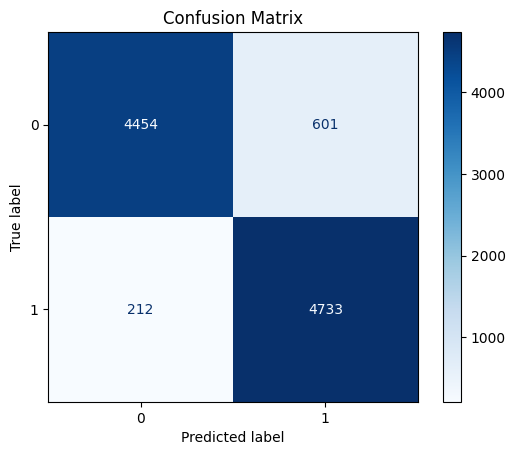

Confusion matrix saved to: /content/drive/MyDrive/SPNLP/Capstone/confusion_matrix_distilbertraw.png
Classification report saved to: /content/drive/MyDrive/SPNLP/Capstone/classification_report_distilbertraw.txt


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Load the fine-tuned model and tokenizer
model_path = '/content/drive/MyDrive/SPNLP/Capstone/distilbert_finetuned_raw'
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# Check GPU availability
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")

# Load test data
test_data_path = '/content/drive/MyDrive/SPNLP/Capstone/rawtest.csv'
test_data = pd.read_csv(test_data_path)

# Preprocessed text and labels
texts = test_data['text'].tolist()
labels = test_data['label'].tolist()

# Function to tokenize and create batches
def tokenize_texts(texts, tokenizer, batch_size=32):
    """Tokenize texts and return batches for inference."""
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    inputs['input_ids'] = inputs['input_ids'].to(device)  # Move to GPU/CPU
    inputs['attention_mask'] = inputs['attention_mask'].to(device)  # Move to GPU/CPU

    # Split into batches
    dataset = torch.utils.data.DataLoader(
        list(zip(inputs['input_ids'], inputs['attention_mask'])),
        batch_size=batch_size
    )
    return dataset

# Tokenize the test data
test_batches = tokenize_texts(texts, tokenizer)

# Evaluate model and save results
def evaluate_model(model, test_batches, labels, save_path_report, save_path_confusion):
    model.eval()
    predictions = []

    with torch.no_grad():
        for input_ids, attention_mask in test_batches:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
            predictions.extend(preds)

    # Generate classification report
    report = classification_report(labels, predictions, output_dict=False)
    print("Classification Report:")
    print(report)

    # Save the report to a text file in Google Drive
    with open(save_path_report, 'w') as file:
        file.write("Classification Report:\n")
        file.write(report)

    # Generate and save confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(save_path_confusion)
    plt.show()
    print(f"Confusion matrix saved to: {save_path_confusion}")

# Specify save paths for results
report_save_path = '/content/drive/MyDrive/SPNLP/Capstone/classification_report_distilbertraw.txt'
confusion_matrix_save_path = '/content/drive/MyDrive/SPNLP/Capstone/confusion_matrix_distilbertraw.png'

# Run evaluation
evaluate_model(model, test_batches, labels, report_save_path, confusion_matrix_save_path)

print(f"Classification report saved to: {report_save_path}")
